## RLDMUU 2025
#### MARL - introduction
jakub.tluczek@unine.ch

In the last lab of the RLDMUU course, we are going to explore the basics of multi agent reinforcement learning. We are going to go through the Petting Zoo workflow (Gymnasium-based framework for multi agent setting), as well as an example end to end training of multiple agents.

In [1]:
import pettingzoo
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import deque
import random
torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(123)

Petting Zoo offer the same environment based workflow as Gymnasium, while offering two APIs for agent interaction:

- Agent Environment Cycle (AEC) API - turn based
- Parallel API - moves are made simultaneously

Petting zoo features similar `step` function we know from Gymnasium, with this difference however, that here we operate on dictionaries, where each agent's observation, reward or action is an entry in the `dict` with agent's identifier serving as a key. Moreover, in AEC API `step` only acts on the environment, while the observations are retrieved using `last` method. Let's take a look at an example, a classic tic-tac-toe game with AEC:

In [ ]:
from pettingzoo.classic import tictactoe_v3

env = tictactoe_v3.env()
env.reset()

# agent_iter is an iterable object that generates an ID of the agent whose turn is it right now
for agent in env.agent_iter():
    observation, reward, termination, truncation, info = env.last()


    if termination or truncation:
        action = None
    else:
        # action mask part in the observation vector tells us which actions are allowed
        mask = observation["action_mask"]

        action = env.action_space(agent).sample(mask)

    env.step(action)
env.close()

Another way to act with multiagent environment is to act in parallel. Agents take action at the same time, without observing the current action of other agents. Observations are retrieved in a similar way as in Gymnasium:

In [3]:
from pettingzoo.butterfly import knights_archers_zombies_v10

env = knights_archers_zombies_v10.parallel_env()
observations, infos = env.reset()

# instead of generating current IDs from iterable, loop until therea are no more active agents
while env.agents:
    # sampling actions for all agents
    actions = {agent: env.action_space(agent).sample() for agent in env.agents}

    observations, rewards, terminations, truncations, infos = env.step(actions)
env.close()

Let's stick to tic-tac-toe for the purpose of this class. The nice thing about classical games is that they have nice, predefined goal (winning) so we don't have to think about the solution concepts. In case of tic tac toe we also assume that it's not in agent's interest to cooperate, as it is ultimately a zero sum game. Though simple, this environment still suffers from usual problems related to MARL - implementing a simple Q-Learning is tricky, since the environment is not stationary, moreover the rewards are incredibly sparse (they are only awarded at the end of the game). 

Let's take a look at the first method, called **self play**. Here we play a game against our own policy, which we update periodically. As we improve our $\pi$, after each time we update the "opponent", it gets better at the game. First, let's reuse the DQN we have coded before, it will form the basis of our policy.

In [4]:
class QNetwork(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim):
        super(QNetwork, self).__init__()
        self.linear1 = nn.Linear(n_states, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, n_actions)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        return self.linear3(x)

At first, agent doesn't know the game at all, so you can initially fill the replay buffer with random games - just sample the action spaces of both players. Remember to use action mask!

In [38]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size
        self.memory = deque([], maxlen=size)

    # this method samples transitions and returns tensors of each type registered in the environment step
    def sample(self, sample_size):
        memory_with_lookahead = deque([(self.memory[i][0], self.memory[i][1], self.memory[i][2], self.memory[i+1][0], self.memory[i][3]) for i in range(len(self.memory) - 1)])
        sample = random.sample(memory_with_lookahead, sample_size)
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        for x in sample:
            states.append(x[0])
            actions.append(x[1])
            rewards.append(x[2])
            next_states.append(x[3])
            dones.append(x[4])
        states = torch.tensor(states).to(device)
        actions = torch.tensor(actions).to(device)
        rewards = torch.tensor(rewards).to(device)
        next_states = torch.tensor(next_states).to(device)
        dones = torch.tensor(dones, dtype=torch.int).to(device)
        return states, actions, rewards, next_states, dones
    
    # add transition to the buffer
    def append(self, item):
        self.memory.append(item)

    def __len__(self):
        return len(self.memory)
    
def parameter_update(source_model, target_model, tau):
    for target_param, source_param in zip(target_model.parameters(), source_model.parameters()):
        target_param.data.copy_(tau * source_param.data + (1.0 - tau)*target_param.data)

Now your task is to define a policy of an agent we want to train, as well as "oponnent" policy. You can reuse the code from Lab 8. Although you can reuse the target network as the "oponnent", remember to turn off gradient updates when picking an oponnent's move. 

In [54]:
NUM_STATES = 3*3*2
NUM_ACTIONS = 9
policy_network = QNetwork(n_states=NUM_STATES, n_actions=NUM_ACTIONS, hidden_dim=128).to(device)
target_network = QNetwork(n_states=NUM_STATES, n_actions=NUM_ACTIONS, hidden_dim=128).to(device)
policy_optimizer = torch.optim.Adam(policy_network.parameters(), lr=1e-4)
replay_buffer = ReplayBuffer(10_000)

Finally your task would be to create a training loop for DQN with self-play. Plot the results after you are finished.

In [78]:
NUM_TRAJECTORIES = 10000
UPDATE_FREQ = 20

gamma = 0.99
EPSILON = 0.1
SOFT_UPDATE = 0.01
BATCH_SIZE = 512


env = tictactoe_v3.env()

# fill the buffer with the random transitions
for _ in tqdm(range(10000)):
    env.reset()
    for agent in env.agent_iter():
        observation, reward, termination, truncation, info = env.last()
        if termination or truncation:
            action = None
        else:
            # action mask part in the observation vector tells us which actions are allowed
            mask = observation["action_mask"]

            action = env.action_space(agent).sample(mask)

        replay_buffer.append((observation['observation'].flatten(), action if action is not None else 0, reward, int(termination)))
        
        env.step(action)
# create an AEC training loop
episode_results = []
policy_losses = []
for tau in tqdm(range(NUM_TRAJECTORIES)):
    episode_reward = 0
    env.reset()
    for agent in env.agent_iter():
        observation, reward, termination, truncation, info = env.last()
        if termination or truncation:
            action = None
        else:
            mask = observation['action_mask']
            if agent == 'player_1':
                action_q_values = policy_network(torch.tensor(observation['observation'].flatten(), dtype=torch.float32).to(device))
                # logging the reward
                episode_reward += reward
            # Detaching gradient when playing as opponent
            elif agent == 'player_2':
                with torch.no_grad():
                    action_q_values = target_network(torch.tensor(observation['observation'].flatten(), dtype=torch.float32).to(device))
            masked_q_values = action_q_values.masked_fill(~torch.tensor(mask, dtype=bool).to(device), float('-inf'))
            action = np.random.choice(
                [torch.argmax(masked_q_values.flatten()).detach().cpu().numpy(),
                 np.random.choice(np.nonzero(mask)[0])],
                 p=[1-EPSILON, EPSILON]
            )
        replay_buffer.append((observation['observation'].flatten(), action if action is not None else 0, reward, int(termination)))
        env.step(action)

    episode_results.append(episode_reward)

    # No warmup needed, transition buffer filled in the beginning
    states, actions, rewards, next_states, dones = replay_buffer.sample(sample_size=BATCH_SIZE)
    # getting the maximizing Q-value
    # max(x) return first x values ordered in a decreasing order
    q_target = target_network(torch.tensor(next_states, dtype=torch.float32).to(device)).detach().max(1)[0]
    # using Q-values of target network only for non-terminal state
    expected_values = rewards + gamma * q_target*(torch.ones(BATCH_SIZE).to(device) - dones)
    # selecting Q-values of actions taken, using current policy network
    # gather() takes only values indicated by a given index, in this case, action taken
    output = policy_network(states.float()).gather(1, actions.view(-1,1))
    # computing the loss between r + γ * max Q(s',a) and Q(s,a)
    loss = F.mse_loss(output.flatten(), expected_values)
    policy_losses.append(loss.item())
    policy_optimizer.zero_grad()
    loss.backward()
    policy_optimizer.step()
    # soft parameter update
    parameter_update(policy_network, target_network, SOFT_UPDATE)
    


  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_1344/352047754.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_target = target_network(torch.tensor(next_states, dtype=torch.float32).to(device)).detach().max(1)[0]
100%|██████████| 10000/10000 [05:37<00:00, 29.66it/s]


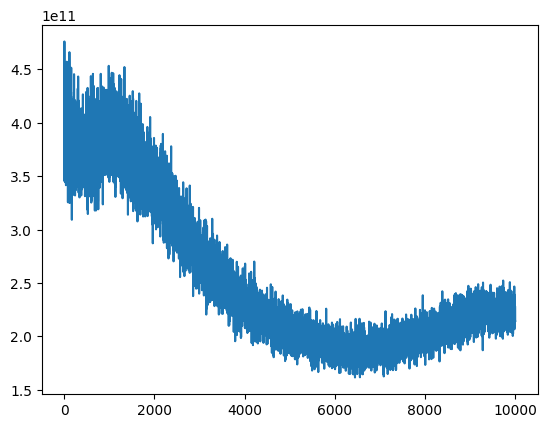

In [79]:
from matplotlib import pyplot as plt

plt.plot(policy_losses)

*BONUS*: Since the rewards are very sparse, you can augment the reward function and use another technique called **curriculum learning**. Using your expert knowledge you can then lead policy into regions that are known to work in the particular game. For example, try awarding agent for putting 2 X's or O's in row without opponents piece.